# 200827 Species overlap components overview

In [1]:
using ProgressMeter
using GZip
using JSON
using Mmap
using DataFrames
using CSV
using StatsBase
using CategoricalArrays
using HDF5
using Markdown
using DataStructures: counter

In [2]:
using PyPlot
using PyCall
sns = pyimport("seaborn")

import PlotlyJS
using PlotlyJS: attr

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-7338688909317524313\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-12281656151553590246\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-7338688909317524313\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [3]:
using Midas
using Midas.Pairwise: npairs
using TriMatrices

## Func defs

In [4]:
findclass(a::CategoricalArray, cls::CategoricalValue) = findall(==(cls), a)
findclass(a::CategoricalArray, i::Integer) = findclass(a, a.pool[i])
findclass(a::CategoricalArray, clss::AbstractVector{<:CategoricalValue}) = findall(∈(clss), a)
findclass(a::CategoricalArray, is::AbstractVector{<:Integer}) = findall(∈(is), a.refs)
selectclass(a::AbstractVector, c::CategoricalArray, cls) = a[findclass(c, cls)]

selectclass (generic function with 1 method)

In [5]:
py"""
import numpy as np
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform


def clustermap_dists(d, method='complete', **kw):
    d2 = squareform(d)
    link = sch.linkage(d, method=method)
    return sns.clustermap(d, row_linkage=link, col_linkage=link, **kw)
"""

clustermap_dists = py"clustermap_dists"

PyObject <function clustermap_dists at 0x7f79972ef8c0>

In [6]:
include("GroupedHeatmaps.jl")
using .GroupedHeatmaps

In [7]:
function mark_overlaps!(hm::GroupedHeatmaps.GroupedHeatmap; labels=nothing)
    T = isnothing(labels) ? Int : eltype(labels)
    
    for (i, gi) in enumerate(hm.groups)
        max_ = [max_intra[ii][2] for ii in gi]
        min_ = [min_inter[ii][2] for ii in gi]
        
        for (j, gj) in enumerate(hm.groups)
            
            x = T[]
            y = T[]
            
            for ii in eachindex(gi)
                for jj in eachindex(gj)
                    d = pw_dists[gi[ii], gj[jj]]
                    if (i == j) ? (d >= min_[ii]) : (d <= max_[ii])
                        if isnothing(labels)
                            push!(x, ii - 1)
                            push!(y, jj - 1)
                        else
                            push!(x, labels[gi[ii]])
                            push!(y, labels[gj[jj]])
                        end
                    end
                end
            end
            
            isempty(x) && continue
            
            tr = PlotlyJS.scatter(
                x=x,
                y=y,
                xaxis="x$i",
                yaxis="y$j",
                mode=:markers,
                marker_color=:white,
                marker_symbol=i == j ? "x" : "circle",
                hoverinfo=:skip,
            )
        
            PlotlyJS.addtraces!(hm.plot, tr)
        end
    end
    
    hm.layout["showlegend"] = false
    
    return nothing
end

mark_overlaps! (generic function with 1 method)

## File paths

In [8]:
intermediate_dir = "../../data/intermediate/200727-find-overlaps/";

In [9]:
infiles = Dict(
    :taxonomy => "/home/jared/notebooks/midas-notebooks-2019/build-v1-database/out/3-curated-taxonomy-assignments.csv",
    :distances => joinpath(intermediate_dir, "genome-pw-distances.raw-float32"),
    :overlaps => joinpath(intermediate_dir, "200729-refseq-curated-1.1_beta-species-overlaps.h5"),
);

## Load data

### Taxonomy

In [10]:
taxdf = DataFrame(CSV.File(infiles[:taxonomy]));

In [11]:
sig_genera = categorical(taxdf[!, :genus])
genera = levels(sig_genera)
ngenera = length(genera)

sig_species = categorical([(row[:genus], row[:species]) for row in eachrow(taxdf)])
species = levels(sig_species)
speciesnames = [join(s, " ") for s in species]
nspecies = length(species)

ngenera, nspecies

(419, 1438)

In [12]:
genus_counts = counts(sig_genera.refs)
species_counts = counts(sig_species.refs)
;

In [13]:
genome_accs = [last(split(k, "/")) for k in taxdf[!, :key]];

In [14]:
species_to_genus = [findfirst(==(genus), genera) for (genus, spname) in species];

In [15]:
nsigs = size(taxdf, 1)

50752

### Distances

In [16]:
pw_data = Mmap.mmap(open(infiles[:distances], "r"), Vector{Float32}, (npairs(nsigs),));

pw_dists = TriMatrix(TriSymmetric{false}(), nsigs, pw_data);

In [17]:
@assert !any(<(0), pw_data)

### Overlaps

In [18]:
h5open(infiles[:overlaps]) do h5
    @assert read(h5, "genome_keys") == taxdf[!, :key]

    global min_inter = collect(zip(read(h5, "min_inter_indices"), read(h5, "min_inter_dists")))
    global max_intra = collect(zip(read(h5, "max_intra_indices"), read(h5, "max_intra_dists")))

    global has_overlap = read(h5, "has_overlap")
    global overlap_components_vec = read(h5, "overlap_components")
end;

In [19]:
overlap_pairs = [i => min_inter[i][1] for i in has_overlap];

In [20]:
overlap_components = [findall(==(i), overlap_components_vec) for i in 1:maximum(overlap_components_vec)];

In [21]:
overlap_edges = counter(
    Int(sig_species.refs[i]) => Int(sig_species.refs[j])
    for (i, j) in overlap_pairs
);

## Component Analysis funcs

In [22]:
function activate_component(ci_::Int)
    global ci = ci_
    global comp = overlap_components[ci]
    global comp_idxs = [findclass(sig_species, c) for c in comp]
    global comp_genera = unique(g for (g, s) in species[comp])
    global singlegenus = length(comp_genera) == 1
    if singlegenus
        global comp_genus = only(comp_genera)
        global grouplabels = [s for (g, s) in species[comp]]
    else
        global comp_genus = nothing
        global groupnames = speciesnames[comp]
    end
    global component_ngenomes = sum(length.(comp_idxs))
end

activate_component (generic function with 1 method)

In [23]:
function component_species_df()
    DataFrame([(genus=species[i][1], species=species[i][2], ngenomes=species_counts[i]) for i in comp])
end

function component_edges_df()
    df = DataFrame([String, String, Int, Float64], [:A, :B, :C, :D])
    
    for ((i, j), c) in overlap_edges
        if i ∈ comp
            push!(df, (
                speciesnames[i],
                speciesnames[j],
                c,
                c / (species_counts[i] * species_counts[j])
            ))
        end
    end
    
    sort!(df, [:A, :B])
    rename!(df, ["Intra Species", "Inter Species", "Overlapping Pairs", "Overlap fraction"])
    
    return df
end

function component_summary_raw()
    buf = IOBuffer()
    
    print(buf, "### Component $ci: ")
    print(buf, join(comp_genera, ", "))
    print(buf, " (", length(comp), " species, ", sum(length.(comp_idxs)), " genomes)")
    print(buf, "\n<br>\n")
    
    sp_df = component_species_df()
    show(buf, MIME"text/html"(), sp_df, eltypes=false, summary=false)
    print(buf, "\n<br>\n")
    
    e_df = component_edges_df()
    show(buf, MIME"text/html"(), e_df, eltypes=false, summary=false)
    
    return buf
end

function component_summary(ci_=nothing)
    isnothing(ci_) || activate_component(ci_)
    
    buf = component_summary_raw()
    seek(buf, 0)
    return Markdown.parse(buf)
end

component_summary (generic function with 2 methods)

In [24]:
function plot_component_dists(ci_=nothing; overlaps=false)
    isnothing(ci_) || activate_component(ci_)

    hm = GroupedHeatmaps.GroupedHeatmap(pw_dists, comp_idxs,
        labels=genome_accs,
        grouplabels=grouplabels,
        colorscale="Jet",
        height=800)
    overlaps && mark_overlaps!(hm, labels=genome_accs)
    PlotlyJS.plot(hm.plot)
end

plot_component_dists (generic function with 2 methods)

In [25]:
function component_report(ci_=nothing)
    isnothing(ci_) || activate_component(ci_)
    buf = component_summary_raw()
    
    showplot = component_ngenomes < 200
    
    !showplot && print(buf, "\n<br>\nToo many genomes, omitting heatmap.")
    print(buf, "\n<br>\n")
    
    seek(buf, 0)
    display(Markdown.parse(buf))
    
    if showplot
        plot_component_dists(overlaps=component_ngenomes < 100)
    end
end

component_report (generic function with 2 methods)

## Reports

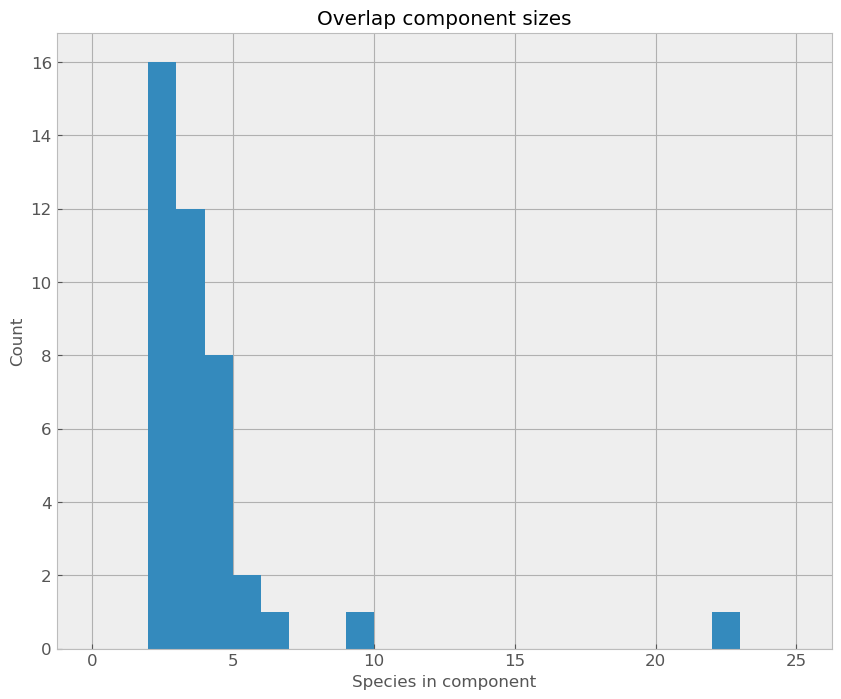

PyObject Text(25.0, 0.5, 'Count')

In [26]:
plt.hist(length.(overlap_components), bins=0:25);
plt.title("Overlap component sizes")
plt.xlabel("Species in component")
plt.ylabel("Count")

In [27]:
component_report(1)

### Component 1: Bacillus (6 species, 332 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Bacillus</td><td>anthracis</td><td>103</td></tr><tr><th>2</th><td>Bacillus</td><td>cereus</td><td>196</td></tr><tr><th>3</th><td>Bacillus</td><td>gaemokensis</td><td>2</td></tr><tr><th>4</th><td>Bacillus</td><td>mycoides</td><td>9</td></tr><tr><th>5</th><td>Bacillus</td><td>thuringiensis</td><td>19</td></tr><tr><th>6</th><td>Bacillus</td><td>weihenstephanensis</td><td>3</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Bacillus cereus</td><td>Bacillus anthracis</td><td>89</td><td>0.00440856</td></tr><tr><th>2</th><td>Bacillus cereus</td><td>Bacillus mycoides</td><td>14</td><td>0.00793651</td></tr><tr><th>3</th><td>Bacillus cereus</td><td>Bacillus thuringiensis</td><td>90</td><td>0.0241676</td></tr><tr><th>4</th><td>Bacillus cereus</td><td>Bacillus weihenstephanensis</td><td>3</td><td>0.00510204</td></tr><tr><th>5</th><td>Bacillus mycoides</td><td>Bacillus cereus</td><td>4</td><td>0.00226757</td></tr><tr><th>6</th><td>Bacillus mycoides</td><td>Bacillus gaemokensis</td><td>5</td><td>0.277778</td></tr><tr><th>7</th><td>Bacillus thuringiensis</td><td>Bacillus cereus</td><td>19</td><td>0.00510204</td></tr></tbody></table> <br> Too many genomes, omitting heatmap. <br>


In [28]:
component_report(2)

### Component 2: Escherichia, Shigella (5 species, 4907 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Escherichia</td><td>coli</td><td>4221</td></tr><tr><th>2</th><td>Shigella</td><td>boydii</td><td>13</td></tr><tr><th>3</th><td>Shigella</td><td>dysenteriae</td><td>6</td></tr><tr><th>4</th><td>Shigella</td><td>flexneri</td><td>104</td></tr><tr><th>5</th><td>Shigella</td><td>sonnei</td><td>563</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Escherichia coli</td><td>Shigella dysenteriae</td><td>9</td><td>0.000355366</td></tr><tr><th>2</th><td>Escherichia coli</td><td>Shigella flexneri</td><td>2</td><td>4.55597e-6</td></tr><tr><th>3</th><td>Escherichia coli</td><td>Shigella sonnei</td><td>4210</td><td>0.00177157</td></tr><tr><th>4</th><td>Shigella boydii</td><td>Shigella dysenteriae</td><td>13</td><td>0.166667</td></tr><tr><th>5</th><td>Shigella dysenteriae</td><td>Escherichia coli</td><td>3</td><td>0.000118455</td></tr><tr><th>6</th><td>Shigella dysenteriae</td><td>Shigella boydii</td><td>3</td><td>0.0384615</td></tr></tbody></table> <br> Too many genomes, omitting heatmap. <br>


In [29]:
component_report(3)

### Component 3: Corynebacterium (3 species, 23 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Corynebacterium</td><td>jeikeium</td><td>19</td></tr><tr><th>2</th><td>Corynebacterium</td><td>urealyticum</td><td>2</td></tr><tr><th>3</th><td>Corynebacterium</td><td>xerosis</td><td>2</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Corynebacterium jeikeium</td><td>Corynebacterium urealyticum</td><td>17</td><td>0.447368</td></tr><tr><th>2</th><td>Corynebacterium jeikeium</td><td>Corynebacterium xerosis</td><td>2</td><td>0.0526316</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis"
]

layout: "layout with fields coloraxis, height, margin, showlegend, width, xaxis1, xaxis2, xaxis3, yaxis1, yaxis2, and yaxis3"

In [30]:
component_report(4)

### Component 4: Vibrio (2 species, 440 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Vibrio</td><td>albensis</td><td>3</td></tr><tr><th>2</th><td>Vibrio</td><td>cholerae</td><td>437</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Vibrio cholerae</td><td>Vibrio albensis</td><td>424</td><td>0.323417</td></tr></tbody></table> <br> Too many genomes, omitting heatmap. <br>


In [31]:
component_report(5)

### Component 5: Pseudomonas (3 species, 1560 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Pseudomonas</td><td>aeruginosa</td><td>1547</td></tr><tr><th>2</th><td>Pseudomonas</td><td>alcaligenes</td><td>4</td></tr><tr><th>3</th><td>Pseudomonas</td><td>denitrificans</td><td>9</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Pseudomonas aeruginosa</td><td>Pseudomonas denitrificans</td><td>1547</td><td>0.111111</td></tr><tr><th>2</th><td>Pseudomonas alcaligenes</td><td>Pseudomonas aeruginosa</td><td>2</td><td>0.000323206</td></tr><tr><th>3</th><td>Pseudomonas denitrificans</td><td>Pseudomonas aeruginosa</td><td>9</td><td>0.000646412</td></tr></tbody></table> <br> Too many genomes, omitting heatmap. <br>


In [32]:
component_report(6)

### Component 6: Streptococcus (3 species, 7114 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Streptococcus</td><td>mitis</td><td>4</td></tr><tr><th>2</th><td>Streptococcus</td><td>pneumoniae</td><td>7099</td></tr><tr><th>3</th><td>Streptococcus</td><td>pseudopneumoniae</td><td>11</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Streptococcus mitis</td><td>Streptococcus pseudopneumoniae</td><td>4</td><td>0.0909091</td></tr><tr><th>2</th><td>Streptococcus pneumoniae</td><td>Streptococcus pseudopneumoniae</td><td>7099</td><td>0.0909091</td></tr><tr><th>3</th><td>Streptococcus pseudopneumoniae</td><td>Streptococcus mitis</td><td>5</td><td>0.113636</td></tr><tr><th>4</th><td>Streptococcus pseudopneumoniae</td><td>Streptococcus pneumoniae</td><td>6</td><td>7.68354e-5</td></tr></tbody></table> <br> Too many genomes, omitting heatmap. <br>


In [33]:
component_report(7)

### Component 7: Citrobacter, Salmonella (3 species, 4657 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Citrobacter</td><td>braakii</td><td>4</td></tr><tr><th>2</th><td>Salmonella</td><td>bongori</td><td>3</td></tr><tr><th>3</th><td>Salmonella</td><td>enterica</td><td>4650</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Salmonella enterica</td><td>Citrobacter braakii</td><td>2</td><td>0.000107527</td></tr><tr><th>2</th><td>Salmonella enterica</td><td>Salmonella bongori</td><td>4648</td><td>0.33319</td></tr></tbody></table> <br> Too many genomes, omitting heatmap. <br>


In [34]:
component_report(8)

### Component 8: Xanthomonas (3 species, 47 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Xanthomonas</td><td>arboricola</td><td>6</td></tr><tr><th>2</th><td>Xanthomonas</td><td>campestris</td><td>29</td></tr><tr><th>3</th><td>Xanthomonas</td><td>vasicola</td><td>12</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Xanthomonas arboricola</td><td>Xanthomonas campestris</td><td>6</td><td>0.0344828</td></tr><tr><th>2</th><td>Xanthomonas campestris</td><td>Xanthomonas arboricola</td><td>24</td><td>0.137931</td></tr><tr><th>3</th><td>Xanthomonas campestris</td><td>Xanthomonas vasicola</td><td>5</td><td>0.0143678</td></tr><tr><th>4</th><td>Xanthomonas vasicola</td><td>Xanthomonas campestris</td><td>12</td><td>0.0344828</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis"
]

layout: "layout with fields coloraxis, height, margin, showlegend, width, xaxis1, xaxis2, xaxis3, yaxis1, yaxis2, and yaxis3"

In [35]:
component_report(9)

### Component 9: Fusobacterium (2 species, 42 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Fusobacterium</td><td>hwasookii</td><td>8</td></tr><tr><th>2</th><td>Fusobacterium</td><td>nucleatum</td><td>34</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Fusobacterium nucleatum</td><td>Fusobacterium hwasookii</td><td>10</td><td>0.0367647</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis"
]

layout: "layout with fields coloraxis, height, margin, showlegend, width, xaxis1, xaxis2, yaxis1, and yaxis2"

In [36]:
component_report(10)

### Component 10: Brucella (4 species, 68 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Brucella</td><td>canis</td><td>14</td></tr><tr><th>2</th><td>Brucella</td><td>ceti</td><td>5</td></tr><tr><th>3</th><td>Brucella</td><td>pinnipedialis</td><td>5</td></tr><tr><th>4</th><td>Brucella</td><td>suis</td><td>44</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Brucella ceti</td><td>Brucella pinnipedialis</td><td>5</td><td>0.2</td></tr><tr><th>2</th><td>Brucella pinnipedialis</td><td>Brucella ceti</td><td>1</td><td>0.04</td></tr><tr><th>3</th><td>Brucella pinnipedialis</td><td>Brucella suis</td><td>1</td><td>0.00454545</td></tr><tr><th>4</th><td>Brucella suis</td><td>Brucella canis</td><td>15</td><td>0.0243506</td></tr><tr><th>5</th><td>Brucella suis</td><td>Brucella pinnipedialis</td><td>29</td><td>0.131818</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis"
]

layout: "layout with fields coloraxis, height, margin, showlegend, width, xaxis1, xaxis2, xaxis3, xaxis4, yaxis1, yaxis2, yaxis3, and yaxis4"

In [37]:
component_report(11)

### Component 11: Pseudomonas (4 species, 36 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Pseudomonas</td><td>fulva</td><td>2</td></tr><tr><th>2</th><td>Pseudomonas</td><td>monteilii</td><td>2</td></tr><tr><th>3</th><td>Pseudomonas</td><td>parafulva</td><td>4</td></tr><tr><th>4</th><td>Pseudomonas</td><td>putida</td><td>28</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Pseudomonas parafulva</td><td>Pseudomonas fulva</td><td>2</td><td>0.25</td></tr><tr><th>2</th><td>Pseudomonas parafulva</td><td>Pseudomonas putida</td><td>2</td><td>0.0178571</td></tr><tr><th>3</th><td>Pseudomonas putida</td><td>Pseudomonas monteilii</td><td>28</td><td>0.5</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis"
]

layout: "layout with fields coloraxis, height, margin, showlegend, width, xaxis1, xaxis2, xaxis3, xaxis4, yaxis1, yaxis2, yaxis3, and yaxis4"

In [38]:
component_report(12)

### Component 12: Achromobacter, Aeromonas, Arcobacter, Bordetella, Campylobacter, Clostridium, Fusobacterium, Mycoplasma, Paeniclostridium, Prochlorococcus, Pseudomonas, Stenotrophomonas (22 species, 1202 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Achromobacter</td><td>piechaudii</td><td>3</td></tr><tr><th>2</th><td>Aeromonas</td><td>enteropelogenes</td><td>3</td></tr><tr><th>3</th><td>Arcobacter</td><td>butzleri</td><td>11</td></tr><tr><th>4</th><td>Bordetella</td><td>hinzii</td><td>10</td></tr><tr><th>5</th><td>Campylobacter</td><td>coli</td><td>257</td></tr><tr><th>6</th><td>Campylobacter</td><td>jejuni</td><td>628</td></tr><tr><th>7</th><td>Clostridium</td><td>perfringens</td><td>17</td></tr><tr><th>8</th><td>Clostridium</td><td>ventriculi</td><td>2</td></tr><tr><th>9</th><td>Fusobacterium</td><td>necrophorum</td><td>29</td></tr><tr><th>10</th><td>Mycoplasma</td><td>iowae</td><td>2</td></tr><tr><th>11</th><td>Paeniclostridium</td><td>sordellii</td><td>41</td></tr><tr><th>12</th><td>Prochlorococcus</td><td>marinus</td><td>29</td></tr><tr><th>13</th><td>Pseudomonas</td><td>balearica</td><td>3</td></tr><tr><th>14</th><td>Pseudomonas</td><td>chlororaphis</td><td>11</td></tr><tr><th>15</th><td>Pseudomonas</td><td>citronellolis</td><td>3</td></tr><tr><th>16</th><td>Pseudomonas</td><td>fluorescens</td><td>38</td></tr><tr><th>17</th><td>Pseudomonas</td><td>fragi</td><td>2</td></tr><tr><th>18</th><td>Pseudomonas</td><td>mediterranea</td><td>5</td></tr><tr><th>19</th><td>Pseudomonas</td><td>psychrophila</td><td>2</td></tr><tr><th>20</th><td>Pseudomonas</td><td>tolaasii</td><td>2</td></tr><tr><th>21</th><td>Pseudomonas</td><td>veronii</td><td>4</td></tr><tr><th>22</th><td>Stenotrophomonas</td><td>maltophilia</td><td>100</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Campylobacter coli</td><td>Campylobacter jejuni</td><td>8</td><td>4.95675e-5</td></tr><tr><th>2</th><td>Prochlorococcus marinus</td><td>Achromobacter piechaudii</td><td>1</td><td>0.0114943</td></tr><tr><th>3</th><td>Prochlorococcus marinus</td><td>Aeromonas enteropelogenes</td><td>1</td><td>0.0114943</td></tr><tr><th>4</th><td>Prochlorococcus marinus</td><td>Arcobacter butzleri</td><td>10</td><td>0.031348</td></tr><tr><th>5</th><td>Prochlorococcus marinus</td><td>Bordetella hinzii</td><td>1</td><td>0.00344828</td></tr><tr><th>6</th><td>Prochlorococcus marinus</td><td>Campylobacter jejuni</td><td>1</td><td>5.49089e-5</td></tr><tr><th>7</th><td>Prochlorococcus marinus</td><td>Clostridium perfringens</td><td>1</td><td>0.0020284</td></tr><tr><th>8</th><td>Prochlorococcus marinus</td><td>Clostridium ventriculi</td><td>2</td><td>0.0344828</td></tr><tr><th>9</th><td>Prochlorococcus marinus</td><td>Fusobacterium necrophorum</td><td>1</td><td>0.00118906</td></tr><tr><th>10</th><td>Prochlorococcus marinus</td><td>Mycoplasma iowae</td><td>2</td><td>0.0344828</td></tr><tr><th>11</th><td>Prochlorococcus marinus</td><td>Paeniclostridium sordellii</td><td>3</td><td>0.00252313</td></tr><tr><th>12</th><td>Prochlorococcus marinus</td><td>Pseudomonas balearica</td><td>1</td><td>0.0114943</td></tr><tr><th>13</th><td>Prochlorococcus marinus</td><td>Pseudomonas citronellolis</td><td>1</td><td>0.0114943</td></tr><tr><th>14</th><td>Prochlorococcus marinus</td><td>Pseudomonas fragi</td><td>2</td><td>0.0344828</td></tr><tr><th>15</th><td>Prochlorococcus marinus</td><td>Pseudomonas psychrophila</td><td>1</td><td>0.0172414</td></tr><tr><th>16</th><td>Prochlorococcus marinus</td><td>Stenotrophomonas maltophilia</td><td>1</td><td>0.000344828</td></tr><tr><th>17</th><td>Pseudomonas fluorescens</td><td>Pseudomonas chlororaphis</td><td>6</td><td>0.0143541</td></tr><tr><th>18</th><td>Pseudomonas fluorescens</td><td>Pseudomonas fragi</td><td>10</td><td>0.131579</td></tr><tr><th>19</th><td>Pseudomonas fluorescens</td><td>Pseudomonas mediterranea</td><td>2</td><td>0.0105263</td></tr><tr><th>20</th><td>Pseudomonas fluorescens</td><td>Pseudomonas tolaasii</td><td>12</td><td>0.157895</td></tr><tr><th>21</th><td>Pseudomonas fluorescens</td><td>Pseudomonas veronii</td><td>8</td><td>0.0526316</td></tr></tbody></table> <br> Too many genomes, omitting heatmap. <br>


In [39]:
component_report(13)

### Component 13: Mycobacterium (4 species, 3579 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Mycobacterium</td><td>africanum</td><td>22</td></tr><tr><th>2</th><td>Mycobacterium</td><td>bovis</td><td>66</td></tr><tr><th>3</th><td>Mycobacterium</td><td>canettii</td><td>5</td></tr><tr><th>4</th><td>Mycobacterium</td><td>tuberculosis</td><td>3486</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Mycobacterium bovis</td><td>Mycobacterium africanum</td><td>30</td><td>0.0206612</td></tr><tr><th>2</th><td>Mycobacterium canettii</td><td>Mycobacterium tuberculosis</td><td>4</td><td>0.000229489</td></tr><tr><th>3</th><td>Mycobacterium tuberculosis</td><td>Mycobacterium africanum</td><td>3486</td><td>0.0454545</td></tr></tbody></table> <br> Too many genomes, omitting heatmap. <br>


In [40]:
component_report(14)

### Component 14: Burkholderia (4 species, 54 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Burkholderia</td><td>anthina</td><td>8</td></tr><tr><th>2</th><td>Burkholderia</td><td>cenocepacia</td><td>20</td></tr><tr><th>3</th><td>Burkholderia</td><td>multivorans</td><td>17</td></tr><tr><th>4</th><td>Burkholderia</td><td>pseudomultivorans</td><td>9</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Burkholderia cenocepacia</td><td>Burkholderia anthina</td><td>2</td><td>0.0125</td></tr><tr><th>2</th><td>Burkholderia cenocepacia</td><td>Burkholderia multivorans</td><td>18</td><td>0.0529412</td></tr><tr><th>3</th><td>Burkholderia multivorans</td><td>Burkholderia cenocepacia</td><td>2</td><td>0.00588235</td></tr><tr><th>4</th><td>Burkholderia multivorans</td><td>Burkholderia pseudomultivorans</td><td>15</td><td>0.0980392</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis"
]

layout: "layout with fields coloraxis, height, margin, showlegend, width, xaxis1, xaxis2, xaxis3, xaxis4, yaxis1, yaxis2, yaxis3, and yaxis4"

In [41]:
component_report(15)

### Component 15: Pseudomonas (4 species, 174 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Pseudomonas</td><td>amygdali</td><td>29</td></tr><tr><th>2</th><td>Pseudomonas</td><td>avellanae</td><td>6</td></tr><tr><th>3</th><td>Pseudomonas</td><td>savastanoi</td><td>25</td></tr><tr><th>4</th><td>Pseudomonas</td><td>syringae</td><td>114</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Pseudomonas amygdali</td><td>Pseudomonas savastanoi</td><td>11</td><td>0.0151724</td></tr><tr><th>2</th><td>Pseudomonas amygdali</td><td>Pseudomonas syringae</td><td>18</td><td>0.00544465</td></tr><tr><th>3</th><td>Pseudomonas savastanoi</td><td>Pseudomonas amygdali</td><td>15</td><td>0.0206897</td></tr><tr><th>4</th><td>Pseudomonas savastanoi</td><td>Pseudomonas syringae</td><td>10</td><td>0.00350877</td></tr><tr><th>5</th><td>Pseudomonas syringae</td><td>Pseudomonas amygdali</td><td>38</td><td>0.0114943</td></tr><tr><th>6</th><td>Pseudomonas syringae</td><td>Pseudomonas avellanae</td><td>72</td><td>0.105263</td></tr><tr><th>7</th><td>Pseudomonas syringae</td><td>Pseudomonas savastanoi</td><td>4</td><td>0.00140351</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z"
]

layout: "layout with fields coloraxis, height, margin, width, xaxis1, xaxis2, xaxis3, xaxis4, yaxis1, yaxis2, yaxis3, and yaxis4"

In [42]:
component_report(16)

### Component 16: Burkholderia (3 species, 460 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Burkholderia</td><td>mallei</td><td>46</td></tr><tr><th>2</th><td>Burkholderia</td><td>pseudomallei</td><td>392</td></tr><tr><th>3</th><td>Burkholderia</td><td>thailandensis</td><td>22</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Burkholderia pseudomallei</td><td>Burkholderia mallei</td><td>3</td><td>0.000166371</td></tr><tr><th>2</th><td>Burkholderia thailandensis</td><td>Burkholderia pseudomallei</td><td>19</td><td>0.00220315</td></tr></tbody></table> <br> Too many genomes, omitting heatmap. <br>


In [43]:
component_report(17)

### Component 17: Lactobacillus (2 species, 48 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Lactobacillus</td><td>casei</td><td>13</td></tr><tr><th>2</th><td>Lactobacillus</td><td>paracasei</td><td>35</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Lactobacillus casei</td><td>Lactobacillus paracasei</td><td>13</td><td>0.0285714</td></tr><tr><th>2</th><td>Lactobacillus paracasei</td><td>Lactobacillus casei</td><td>35</td><td>0.0769231</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis"
]

layout: "layout with fields coloraxis, height, margin, showlegend, width, xaxis1, xaxis2, yaxis1, and yaxis2"

In [44]:
component_report(18)

### Component 18: Bacillus (2 species, 36 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Bacillus</td><td>amyloliquefaciens</td><td>20</td></tr><tr><th>2</th><td>Bacillus</td><td>velezensis</td><td>16</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Bacillus amyloliquefaciens</td><td>Bacillus velezensis</td><td>20</td><td>0.0625</td></tr><tr><th>2</th><td>Bacillus velezensis</td><td>Bacillus amyloliquefaciens</td><td>16</td><td>0.05</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis"
]

layout: "layout with fields coloraxis, height, margin, showlegend, width, xaxis1, xaxis2, yaxis1, and yaxis2"

In [45]:
component_report(19)

### Component 19: Yersinia (2 species, 305 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Yersinia</td><td>pestis</td><td>265</td></tr><tr><th>2</th><td>Yersinia</td><td>pseudotuberculosis</td><td>40</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Yersinia pseudotuberculosis</td><td>Yersinia pestis</td><td>40</td><td>0.00377358</td></tr></tbody></table> <br> Too many genomes, omitting heatmap. <br>


In [46]:
component_report(20)

### Component 20: Clostridium (4 species, 143 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Clostridium</td><td>botulinum</td><td>116</td></tr><tr><th>2</th><td>Clostridium</td><td>butyricum</td><td>12</td></tr><tr><th>3</th><td>Clostridium</td><td>haemolyticum</td><td>2</td></tr><tr><th>4</th><td>Clostridium</td><td>sporogenes</td><td>13</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Clostridium botulinum</td><td>Clostridium butyricum</td><td>10</td><td>0.00718391</td></tr><tr><th>2</th><td>Clostridium botulinum</td><td>Clostridium haemolyticum</td><td>26</td><td>0.112069</td></tr><tr><th>3</th><td>Clostridium botulinum</td><td>Clostridium sporogenes</td><td>80</td><td>0.0530504</td></tr><tr><th>4</th><td>Clostridium sporogenes</td><td>Clostridium botulinum</td><td>13</td><td>0.00862069</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z"
]

layout: "layout with fields coloraxis, height, margin, width, xaxis1, xaxis2, xaxis3, xaxis4, yaxis1, yaxis2, yaxis3, and yaxis4"

In [47]:
component_report(21)

### Component 21: Rhizobium (2 species, 33 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Rhizobium</td><td>etli</td><td>6</td></tr><tr><th>2</th><td>Rhizobium</td><td>leguminosarum</td><td>27</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Rhizobium leguminosarum</td><td>Rhizobium etli</td><td>4</td><td>0.0246914</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis"
]

layout: "layout with fields coloraxis, height, margin, showlegend, width, xaxis1, xaxis2, yaxis1, and yaxis2"

In [48]:
component_report(22)

### Component 22: Corynebacterium (4 species, 12 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Corynebacterium</td><td>accolens</td><td>2</td></tr><tr><th>2</th><td>Corynebacterium</td><td>aurimucosum</td><td>6</td></tr><tr><th>3</th><td>Corynebacterium</td><td>minutissimum</td><td>2</td></tr><tr><th>4</th><td>Corynebacterium</td><td>pseudodiphtheriticum</td><td>2</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Corynebacterium aurimucosum</td><td>Corynebacterium accolens</td><td>2</td><td>0.166667</td></tr><tr><th>2</th><td>Corynebacterium aurimucosum</td><td>Corynebacterium minutissimum</td><td>2</td><td>0.166667</td></tr><tr><th>3</th><td>Corynebacterium aurimucosum</td><td>Corynebacterium pseudodiphtheriticum</td><td>2</td><td>0.166667</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis"
]

layout: "layout with fields coloraxis, height, margin, showlegend, width, xaxis1, xaxis2, xaxis3, xaxis4, yaxis1, yaxis2, yaxis3, and yaxis4"

In [49]:
component_report(23)

### Component 23: Cronobacter (3 species, 52 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Cronobacter</td><td>sakazakii</td><td>45</td></tr><tr><th>2</th><td>Cronobacter</td><td>turicensis</td><td>4</td></tr><tr><th>3</th><td>Cronobacter</td><td>universalis</td><td>3</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Cronobacter turicensis</td><td>Cronobacter sakazakii</td><td>2</td><td>0.0111111</td></tr><tr><th>2</th><td>Cronobacter turicensis</td><td>Cronobacter universalis</td><td>2</td><td>0.166667</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis"
]

layout: "layout with fields coloraxis, height, margin, showlegend, width, xaxis1, xaxis2, xaxis3, yaxis1, yaxis2, and yaxis3"

In [50]:
component_report(24)

### Component 24: Vibrio (3 species, 36 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Vibrio</td><td>crassostreae</td><td>14</td></tr><tr><th>2</th><td>Vibrio</td><td>splendidus</td><td>16</td></tr><tr><th>3</th><td>Vibrio</td><td>tasmaniensis</td><td>6</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Vibrio crassostreae</td><td>Vibrio splendidus</td><td>14</td><td>0.0625</td></tr><tr><th>2</th><td>Vibrio splendidus</td><td>Vibrio crassostreae</td><td>16</td><td>0.0714286</td></tr><tr><th>3</th><td>Vibrio tasmaniensis</td><td>Vibrio splendidus</td><td>6</td><td>0.0625</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis"
]

layout: "layout with fields coloraxis, height, margin, showlegend, width, xaxis1, xaxis2, xaxis3, yaxis1, yaxis2, and yaxis3"

In [51]:
component_report(25)

### Component 25: Streptomyces (3 species, 12 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Streptomyces</td><td>albus</td><td>6</td></tr><tr><th>2</th><td>Streptomyces</td><td>bikiniensis</td><td>3</td></tr><tr><th>3</th><td>Streptomyces</td><td>californicus</td><td>3</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Streptomyces albus</td><td>Streptomyces bikiniensis</td><td>2</td><td>0.111111</td></tr><tr><th>2</th><td>Streptomyces albus</td><td>Streptomyces californicus</td><td>1</td><td>0.0555556</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis"
]

layout: "layout with fields coloraxis, height, margin, showlegend, width, xaxis1, xaxis2, xaxis3, yaxis1, yaxis2, and yaxis3"

In [52]:
component_report(26)

### Component 26: Yersinia (5 species, 173 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Yersinia</td><td>aleksiciae</td><td>2</td></tr><tr><th>2</th><td>Yersinia</td><td>bercovieri</td><td>3</td></tr><tr><th>3</th><td>Yersinia</td><td>enterocolitica</td><td>140</td></tr><tr><th>4</th><td>Yersinia</td><td>frederiksenii</td><td>22</td></tr><tr><th>5</th><td>Yersinia</td><td>rohdei</td><td>6</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Yersinia frederiksenii</td><td>Yersinia aleksiciae</td><td>5</td><td>0.113636</td></tr><tr><th>2</th><td>Yersinia frederiksenii</td><td>Yersinia bercovieri</td><td>1</td><td>0.0151515</td></tr><tr><th>3</th><td>Yersinia frederiksenii</td><td>Yersinia enterocolitica</td><td>3</td><td>0.000974026</td></tr><tr><th>4</th><td>Yersinia frederiksenii</td><td>Yersinia rohdei</td><td>13</td><td>0.0984848</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z"
]

layout: "layout with fields coloraxis, height, margin, width, xaxis1, xaxis2, xaxis3, xaxis4, xaxis5, yaxis1, yaxis2, yaxis3, yaxis4, and yaxis5"

In [53]:
component_report(27)

### Component 27: Bacillus (2 species, 26 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Bacillus</td><td>pumilus</td><td>22</td></tr><tr><th>2</th><td>Bacillus</td><td>safensis</td><td>4</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Bacillus pumilus</td><td>Bacillus safensis</td><td>21</td><td>0.238636</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis"
]

layout: "layout with fields coloraxis, height, margin, showlegend, width, xaxis1, xaxis2, yaxis1, and yaxis2"

In [54]:
component_report(28)

### Component 28: Bifidobacterium, Chlamydia, Gardnerella, Granulicoccus, Neisseria (9 species, 1221 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Bifidobacterium</td><td>pseudocatenulatum</td><td>5</td></tr><tr><th>2</th><td>Chlamydia</td><td>trachomatis</td><td>115</td></tr><tr><th>3</th><td>Gardnerella</td><td>vaginalis</td><td>42</td></tr><tr><th>4</th><td>Granulicoccus</td><td>phenolivorans</td><td>2</td></tr><tr><th>5</th><td>Neisseria</td><td>gonorrhoeae</td><td>326</td></tr><tr><th>6</th><td>Neisseria</td><td>lactamica</td><td>6</td></tr><tr><th>7</th><td>Neisseria</td><td>meningitidis</td><td>721</td></tr><tr><th>8</th><td>Neisseria</td><td>mucosa</td><td>2</td></tr><tr><th>9</th><td>Neisseria</td><td>polysaccharea</td><td>2</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Gardnerella vaginalis</td><td>Bifidobacterium pseudocatenulatum</td><td>1</td><td>0.0047619</td></tr><tr><th>2</th><td>Gardnerella vaginalis</td><td>Chlamydia trachomatis</td><td>17</td><td>0.00351967</td></tr><tr><th>3</th><td>Gardnerella vaginalis</td><td>Granulicoccus phenolivorans</td><td>2</td><td>0.0238095</td></tr><tr><th>4</th><td>Gardnerella vaginalis</td><td>Neisseria gonorrhoeae</td><td>22</td><td>0.00160678</td></tr><tr><th>5</th><td>Neisseria lactamica</td><td>Neisseria meningitidis</td><td>3</td><td>0.000693481</td></tr><tr><th>6</th><td>Neisseria lactamica</td><td>Neisseria polysaccharea</td><td>3</td><td>0.25</td></tr><tr><th>7</th><td>Neisseria meningitidis</td><td>Neisseria gonorrhoeae</td><td>714</td><td>0.0030377</td></tr><tr><th>8</th><td>Neisseria meningitidis</td><td>Neisseria lactamica</td><td>2</td><td>0.000462321</td></tr><tr><th>9</th><td>Neisseria meningitidis</td><td>Neisseria mucosa</td><td>5</td><td>0.00346741</td></tr></tbody></table> <br> Too many genomes, omitting heatmap. <br>


In [55]:
component_report(29)

### Component 29: Streptococcus (2 species, 20 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Streptococcus</td><td>salivarius</td><td>17</td></tr><tr><th>2</th><td>Streptococcus</td><td>vestibularis</td><td>3</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Streptococcus salivarius</td><td>Streptococcus vestibularis</td><td>15</td><td>0.294118</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis"
]

layout: "layout with fields coloraxis, height, margin, showlegend, width, xaxis1, xaxis2, yaxis1, and yaxis2"

In [56]:
component_report(30)

### Component 30: Chlamydia (2 species, 51 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Chlamydia</td><td>abortus</td><td>3</td></tr><tr><th>2</th><td>Chlamydia</td><td>psittaci</td><td>48</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Chlamydia psittaci</td><td>Chlamydia abortus</td><td>48</td><td>0.333333</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis"
]

layout: "layout with fields coloraxis, height, margin, showlegend, width, xaxis1, xaxis2, yaxis1, and yaxis2"

In [57]:
component_report(31)

### Component 31: Xanthomonas (2 species, 36 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Xanthomonas</td><td>alfalfae</td><td>3</td></tr><tr><th>2</th><td>Xanthomonas</td><td>perforans</td><td>33</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Xanthomonas alfalfae</td><td>Xanthomonas perforans</td><td>1</td><td>0.010101</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis"
]

layout: "layout with fields coloraxis, height, margin, showlegend, width, xaxis1, xaxis2, yaxis1, and yaxis2"

In [58]:
component_report(32)

### Component 32: Streptomyces (4 species, 43 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Streptomyces</td><td>hygroscopicus</td><td>6</td></tr><tr><th>2</th><td>Streptomyces</td><td>pluripotens</td><td>2</td></tr><tr><th>3</th><td>Streptomyces</td><td>rimosus</td><td>33</td></tr><tr><th>4</th><td>Streptomyces</td><td>varsoviensis</td><td>2</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Streptomyces hygroscopicus</td><td>Streptomyces pluripotens</td><td>3</td><td>0.25</td></tr><tr><th>2</th><td>Streptomyces hygroscopicus</td><td>Streptomyces rimosus</td><td>2</td><td>0.010101</td></tr><tr><th>3</th><td>Streptomyces hygroscopicus</td><td>Streptomyces varsoviensis</td><td>1</td><td>0.0833333</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis"
]

layout: "layout with fields coloraxis, height, margin, showlegend, width, xaxis1, xaxis2, xaxis3, xaxis4, yaxis1, yaxis2, yaxis3, and yaxis4"

In [59]:
component_report(33)

### Component 33: Vibrio (3 species, 36 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Vibrio</td><td>harveyi</td><td>27</td></tr><tr><th>2</th><td>Vibrio</td><td>hyugaensis</td><td>3</td></tr><tr><th>3</th><td>Vibrio</td><td>owensii</td><td>6</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Vibrio harveyi</td><td>Vibrio hyugaensis</td><td>3</td><td>0.037037</td></tr><tr><th>2</th><td>Vibrio harveyi</td><td>Vibrio owensii</td><td>24</td><td>0.148148</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis"
]

layout: "layout with fields coloraxis, height, margin, showlegend, width, xaxis1, xaxis2, xaxis3, yaxis1, yaxis2, and yaxis3"

In [60]:
component_report(34)

### Component 34: Bradyrhizobium (3 species, 21 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Bradyrhizobium</td><td>diazoefficiens</td><td>4</td></tr><tr><th>2</th><td>Bradyrhizobium</td><td>japonicum</td><td>15</td></tr><tr><th>3</th><td>Bradyrhizobium</td><td>liaoningense</td><td>2</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Bradyrhizobium japonicum</td><td>Bradyrhizobium diazoefficiens</td><td>13</td><td>0.216667</td></tr><tr><th>2</th><td>Bradyrhizobium japonicum</td><td>Bradyrhizobium liaoningense</td><td>2</td><td>0.0666667</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis"
]

layout: "layout with fields coloraxis, height, margin, showlegend, width, xaxis1, xaxis2, xaxis3, yaxis1, yaxis2, and yaxis3"

In [61]:
component_report(35)

### Component 35: Lysinibacillus (2 species, 13 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Lysinibacillus</td><td>fusiformis</td><td>5</td></tr><tr><th>2</th><td>Lysinibacillus</td><td>sphaericus</td><td>8</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Lysinibacillus fusiformis</td><td>Lysinibacillus sphaericus</td><td>4</td><td>0.1</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis"
]

layout: "layout with fields coloraxis, height, margin, showlegend, width, xaxis1, xaxis2, yaxis1, and yaxis2"

In [62]:
component_report(36)

### Component 36: Enterobacter (3 species, 300 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Enterobacter</td><td>cloacae</td><td>98</td></tr><tr><th>2</th><td>Enterobacter</td><td>hormaechei</td><td>192</td></tr><tr><th>3</th><td>Enterobacter</td><td>xiangfangensis</td><td>10</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Enterobacter cloacae</td><td>Enterobacter hormaechei</td><td>96</td><td>0.00510204</td></tr><tr><th>2</th><td>Enterobacter cloacae</td><td>Enterobacter xiangfangensis</td><td>2</td><td>0.00204082</td></tr><tr><th>3</th><td>Enterobacter hormaechei</td><td>Enterobacter cloacae</td><td>192</td><td>0.0102041</td></tr></tbody></table> <br> Too many genomes, omitting heatmap. <br>


In [63]:
component_report(37)

### Component 37: Salinispora (2 species, 48 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Salinispora</td><td>pacifica</td><td>37</td></tr><tr><th>2</th><td>Salinispora</td><td>tropica</td><td>11</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Salinispora pacifica</td><td>Salinispora tropica</td><td>2</td><td>0.004914</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis"
]

layout: "layout with fields coloraxis, height, margin, showlegend, width, xaxis1, xaxis2, yaxis1, and yaxis2"

In [64]:
component_report(38)

### Component 38: Burkholderia (2 species, 67 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Burkholderia</td><td>cepacia</td><td>65</td></tr><tr><th>2</th><td>Burkholderia</td><td>lata</td><td>2</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Burkholderia cepacia</td><td>Burkholderia lata</td><td>65</td><td>0.5</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis"
]

layout: "layout with fields coloraxis, height, margin, showlegend, width, xaxis1, xaxis2, yaxis1, and yaxis2"

In [65]:
component_report(39)

### Component 39: Bacillus (2 species, 24 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Bacillus</td><td>licheniformis</td><td>18</td></tr><tr><th>2</th><td>Bacillus</td><td>paralicheniformis</td><td>6</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Bacillus licheniformis</td><td>Bacillus paralicheniformis</td><td>1</td><td>0.00925926</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis"
]

layout: "layout with fields coloraxis, height, margin, showlegend, width, xaxis1, xaxis2, yaxis1, and yaxis2"

In [66]:
component_report(40)

### Component 40: Borrelia (2 species, 5 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Borrelia</td><td>crocidurae</td><td>3</td></tr><tr><th>2</th><td>Borrelia</td><td>duttonii</td><td>2</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Borrelia crocidurae</td><td>Borrelia duttonii</td><td>1</td><td>0.166667</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis"
]

layout: "layout with fields coloraxis, height, margin, showlegend, width, xaxis1, xaxis2, yaxis1, and yaxis2"

In [67]:
component_report(41)

### Component 41: Pandoraea (2 species, 11 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Pandoraea</td><td>apista</td><td>4</td></tr><tr><th>2</th><td>Pandoraea</td><td>pnomenusa</td><td>7</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Pandoraea pnomenusa</td><td>Pandoraea apista</td><td>2</td><td>0.0714286</td></tr></tbody></table> <br>


data: [
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "heatmap with fields coloraxis, name, type, x, xaxis, y, yaxis, and z",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis",
  "scatter with fields hoverinfo, marker, mode, type, x, xaxis, y, and yaxis"
]

layout: "layout with fields coloraxis, height, margin, showlegend, width, xaxis1, xaxis2, yaxis1, and yaxis2"